# **Project: Amazon Product Recommendation System**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 8.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357295 sha256=e4a9a554eb3dcc16866114a235b2664c143e135d4aa436934ee5184433c0e2c8
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from collections import defaultdict


### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
# Load Data
df = pd.read_csv('/content/drive/MyDrive/ratings_Electronics.csv', header = None)

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

df = df.drop('timestamp', axis = 1)

df_copy = df.copy(deep = True)

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)

**Write your observations here:** There are a significantly vastly more number of rows compared to just 3 columns making the data set very sparse.

### **Data types**

In [ ]:
# Check Data types and provide observations
df_final.dtypes

,0
user_id,object
prod_id,object
rating,float64


**Write your observations here:** Two of the three columns are of object type, but written numerically, and rating is of float type, but is actually categorical since there are only a set amount of numbers the rating variable can take.

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
missing_values = df_final.isnull().sum()

print("Missing values in each column:")
print(missing_values)

# Display columns that have missing values
missing_values_columns = missing_values[missing_values > 0]

if not missing_values_columns.empty:
    print("\nColumns with missing values:")
    print(missing_values_columns)
else:
    print("\nNo missing values found in the dataset.")

Missing values in each column:
user_id    0
prod_id    0
rating     0
dtype: int64

No missing values found in the dataset.


**Write your observations here:** I didn't find any missing values for this data set so no additional work needs to be done.

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
rating_summary = df_final['rating'].describe()

# Display the summary statistics
print("Summary Statistics for 'rating' variable:")
print(rating_summary)

Summary Statistics for 'rating' variable:
count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


**Write your observations here:** The average rating is relatively high at ~4.3 out of 5 stars with a moderately ranged standard deviation at around 1. The median is 5 stars showing a disproportionate amout of 5 stars compared to any other rating in the data set.

### **Checking the rating distribution**

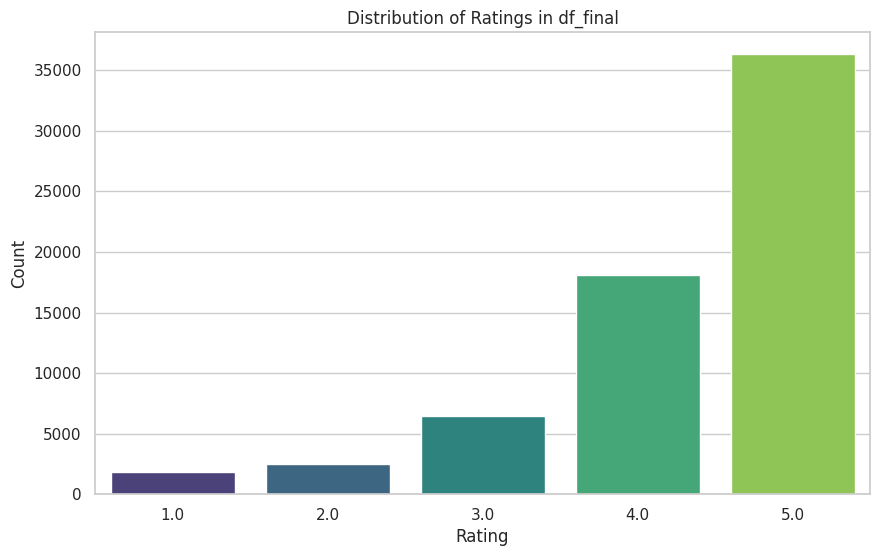

In [ ]:
# Create the bar plot and provide observations
import seaborn as sns
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df_final, palette='viridis')

plt.title('Distribution of Ratings in df_final')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.show()

**Write your observations here:** As follows from my previous observation, we do find that the most ratings are indeed 5 star ratings, having more 5 star ratings counted than all the other rating combined, with 4 star rating count being about half as much, and 1 to 3 star ratings being practically negligible in comparison.

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
total_rows = df_final.shape[0]

unique_user_ids = df_final['user_id'].nunique()
unique_product_ids = df_final['prod_id'].nunique()

# Results
print(f"Total number of rows in the data: {total_rows}")
print(f"Number of unique user IDs: {unique_user_ids}")
print(f"Number of unique product IDs: {unique_product_ids}")

Total number of rows in the data: 65290
Number of unique user IDs: 1540
Number of unique product IDs: 5689


**Write your observations here:** We see that compared to total rows, neither user IDs are product IDs are completely unique across all of the rows, with about 1/50 of rows having unique user IDs and around 1/10 having unique product IDs.

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
user_rating_counts = df_final.groupby('user_id').size().sort_values(ascending=False)

top_10 = user_rating_counts.head(10)

# Display the top 10 users and their rating counts
print("Top 10 Users Based on the Number of Ratings:")
print(top_10)

Top 10 Users Based on the Number of Ratings:
user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64


**Write your observations here:** We see that most of the users in the top 10 greatly exceed the 1:50 ratio between rows and unique User IDs with all of them having triple digit numbers of ratings with the user that gave the most ratings even having ~300 total ratings!

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
average_rating_per_product = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating_per_product = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({
    'average_rating': average_rating_per_product,
    'rating_count': count_rating_per_product
})
# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by='average_rating', ascending=False)

# See the first five records of the "final_rating" dataset
print("First five records of the final_rating dataset:")
print(final_rating.head())

First five records of the final_rating dataset:
            average_rating  rating_count
prod_id                                 
B00LGQ6HL8             5.0             5
B003DZJQQI             5.0            14
B005FDXF2C             5.0             7
B00I6CVPVC             5.0             7
B00B9KOCYA             5.0             8


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def get_top_n_products(dataframe, n, min_interactions):
    average_rating_per_product = dataframe.groupby('prod_id')['rating'].mean()
    count_rating_per_product = dataframe.groupby('prod_id')['rating'].count()
    final_rating = pd.DataFrame({
        'average_rating': average_rating_per_product,
        'rating_count': count_rating_per_product
    })

    filtered_rating = final_rating[final_rating['rating_count'] >= min_interactions]
    sorted_rating = filtered_rating.sort_values(by='average_rating', ascending=False)
    return sorted_rating.head(n)

# Finding products with minimum number of interactions
min_interactions = 50
n = 10

top_products = get_top_n_products(df_final, n, min_interactions)

# Sorting values with respect to average rating
print(f"Top {n} products with at least {min_interactions} interactions, sorted by average rating:")
print(top_products)

Top 10 products with at least 50 interactions, sorted by average rating:
            average_rating  rating_count
prod_id                                 
B001TH7GUU        4.871795            78
B003ES5ZUU        4.864130           184
B0019EHU8G        4.855556            90
B006W8U2MU        4.824561            57
B000QUUFRW        4.809524            84
B000HPV3RW        4.803922            51
B001TH7GSW        4.803279            61
B000BQ7GW8        4.777778            54
B000N99BBC        4.772455           167
B002WE6D44        4.770000           100


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
print(f"Top 5 products with at least 50 interactions, sorted by average rating:")
print(get_top_n_products(df_final, 5, 50))

Top 5 products with at least 50 interactions, sorted by average rating:
            average_rating  rating_count
prod_id                                 
B001TH7GUU        4.871795            78
B003ES5ZUU        4.864130           184
B0019EHU8G        4.855556            90
B006W8U2MU        4.824561            57
B000QUUFRW        4.809524            84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
print(f"Top 5 products with at least 100 interactions, sorted by average rating:")
print(get_top_n_products(df_final, 5, 100))

Top 5 products with at least 100 interactions, sorted by average rating:
            average_rating  rating_count
prod_id                                 
B003ES5ZUU        4.864130           184
B000N99BBC        4.772455           167
B002WE6D44        4.770000           100
B007WTAJTO        4.701220           164
B002V88HFE        4.698113           106


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',
    'user_based': True
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
model = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(model, k=10, threshold=3.5)


RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Write your observations here:** The recommendation system appears to perform really well with precision, recall, and F1 score all being >= 0.85 when the maximum is 1.00.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
user_id = 'A3LDPF5FMB782Z'
product_id = '1400501466'

predicted_rating = model.predict(user_id, product_id)
print(f"Predicted rating for user {user_id} on product {product_id}: {predicted_rating.est:.2f}")


Predicted rating for user A3LDPF5FMB782Z on product 1400501466: 3.40


**Write your observations here:** This prediction shows that the rating should be on the lower end being around 3.4. Given that around 50% of ratings are 5 star ratings, this prediction may be slightly wrong.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
filtered_df = df_final[df_final['prod_id'] != "1400501466"]
unique_user_ids = filtered_df['user_id'].unique()

print("Unique user_id where prod_id is not equal to '1400501466':")
print(unique_user_ids)

Unique user_id where prod_id is not equal to '1400501466':
['A2ZR3YTMEEIIZ4' 'A3CLWR1UUZT6TG' 'A5JLAU2ARJ0BO' ... 'A215WH6RUDUCMP'
 'A38C12950IM24P' 'A2J4XMWKR8PPD0']


* It can be observed from the above list that **user "A2ZR3YTMEEIIZ4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
user_id = 'A34BZM6S9L7QI4'
product_id = '1400501466'

predicted_rating = model.predict(user_id, product_id)
print(f"Predicted rating for user {user_id} on product {product_id}: {predicted_rating.est:.2f}")

Predicted rating for user A34BZM6S9L7QI4 on product 1400501466: 4.29


**Write your observations here:** With a non interacted product, we see the recommendation system gives a predicted much higher rating of 4.29 which may be more accurate.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import GridSearchCV
param_grid = {
    'k': [20, 30],
    'min_k': [5],
    'sim_options': {
        'name': ['cosine', 'msd'],
        'user_based': [True]
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
grid_search.fit(data)

# Best RMSE score
best_rmse = grid_search.best_score['rmse']
print(f"Best RMSE score: {best_rmse:.4f}")

# Combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']
print("Best combination of parameters:")
print(best_params)

Best RMSE score: 0.9705
Best combination of parameters:
{'k': 30, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
optimized_model = KNNBasic(k=best_params['k'],
                 min_k=best_params['min_k'],
                 sim_options=best_params['sim_options'])

# Creating an instance of KNNBasic with optimal hyperparameter values
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Training the algorithm on the trainset
optimized_model.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(optimized_model, k=10, threshold=3.5)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9510
Precision:  0.849
Recall:  0.893
F_1 score:  0.87


**Write your observations here:** We see that RMSE is better in this model and both Recall and F1 score have noticeable improvements while Precision very slightly declines. Overall performance, as expected, seems better with the optimized model.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
predicted_rating_optimized_A3LDPF5FMB782Z = optimized_model.predict("A3LDPF5FMB782Z", "1400501466")
print(f"Optimized model prediction for A3LDPF5FMB782Z on prod_id 1400501466: {predicted_rating_optimized_A3LDPF5FMB782Z.est:.2f}")

Optimized model prediction for A3LDPF5FMB782Z on prod_id 1400501466: 3.40


In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
predicted_rating_optimized_A34BZM6S9L7QI4 = optimized_model.predict("A34BZM6S9L7QI4", "1400501466")
print(f"Optimized model prediction for A34BZM6S9L7QI4 on prod_id 1400501466: {predicted_rating_optimized_A34BZM6S9L7QI4.est:.2f}")

Optimized model prediction for A34BZM6S9L7QI4 on prod_id 1400501466: 4.29


**Write your observations here:** The exact same predictions were given with the optimized model and the baseline model, so it seems that the models may both be accurate.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

sim_options = {
    'name': 'msd',
    'user_based': True
}

# Train the model
knn_msd = KNNBasic(sim_options=sim_options)
knn_msd.fit(trainset)

neighbors = knn_msd.get_neighbors(0, k=5)

similar_users = [trainset.to_raw_uid(neighbor) for neighbor in neighbors]

# Display the similar users
print(f"The 5 most similar users to user with internal id 0 are: {similar_users}")

Computing the msd similarity matrix...
Done computing similarity matrix.
The 5 most similar users to user with internal id 0 are: ['A16J281SJ9QXIQ', 'A3CJ7MHAS9IMAM', 'A2L0F2T1DLTNT8', 'AYMD77ITD15PT', 'A21I62TCDL4754']


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
sim_options = {
    'name': 'cosine',
    'user_based': True
}
knn_algo = KNNBasic(sim_options=sim_options)
knn_algo.fit(trainset)
top_5_recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", top_n=5, algo=knn_algo)
print(top_5_recommendations)

Computing the cosine similarity matrix...
Done computing similarity matrix.
[('1400599997', 5), ('B00000DM9W', 5), ('B00000K4KH', 5), ('B00001W0DI', 5), ('B00002EQCW', 5)]


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(top_5_recommendations, columns=["prod_id", "predicted_ratings"])

print("DataFrame of top 5 product recommendations:")
print(recommendations_df)

DataFrame of top 5 product recommendations:
      prod_id  predicted_ratings
0  1400599997                  5
1  B00000DM9W                  5
2  B00000K4KH                  5
3  B00001W0DI                  5
4  B00002EQCW                  5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',
    'user_based': False
}

# KNN algorithm is used to find desired similar items. Use random_state=1
knn_algo = KNNBasic(sim_options=sim_options, random_state=1)

# Train the algorithm on the trainset, and predict ratings for the test set
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
knn_algo.fit(trainset)
predictions = knn_algo.test(testset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(knn_algo, k=10, threshold=3.5)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


**Write your observations here:** This model has a relatively high RMSE, and lower F1, recall, and precision compared to previous models but still work well.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product

predicted_rating = knn_algo.predict(uid="A3LDPF5FMB782Z", iid="1400501466")

# Displaying the predicted rating
print(f"Predicted rating for user 'A3LDPF5FMB782Z' on product '1400501466': {predicted_rating.est:.2f}")


Predicted rating for user 'A3LDPF5FMB782Z' on product '1400501466': 4.27


**Write your observations here:** This time we got a much different score for A3LDPF5FMB782Z with this one being around 4.27 compared to the previous 3.40 score showing an expected increase.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product

predicted_rating = knn_algo.predict(uid="A34BZM6S9L7QI4", iid="1400501466")

# Displaying the predicted rating
print(f"Predicted rating for user 'A34BZM6S9L7QI4' on product '1400501466': {predicted_rating.est:.2f}")

Predicted rating for user 'A34BZM6S9L7QI4' on product '1400501466': 4.29


**Write your observations here:** This score is once again the same as the previous models', both optimized and not optimized, scores showing great precision in this prediction across all models.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],
    'min_k': [3, 6, 9],
    'sim_options': {
        'name': ['msd', 'cosine'],
        'user_based': [False]
    }
}

# Performing 3-fold cross validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
grid_search.fit(data)

# Find the best RMSE score
best_rmse = grid_search.best_score['rmse']
print(f"Best RMSE score: {best_rmse:.4f}")

# Find the combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']
print("Best combination of parameters:")
print(best_params)

Best RMSE score: 0.9755
Best combination of parameters:
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
knn_optimized = KNNBasic(
    k=best_params['k'],
    min_k=best_params['min_k'],
    sim_options=best_params['sim_options']
)

# Creating an instance of KNNBasic with optimal hyperparameter values
knn_optimized.fit(trainset)

# Training the algorithm on the trainset
predictions = knn_optimized.test(testset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(knn_optimized, k=10, threshold=3.5)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9576
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


**Write your observations here:** The optimized model increased its performance from baseline in nearly every category of the similarity matrix. RMSE was noticeably reduced to 0.9579 while recall and F_1 score had a noticeable increase in performance and precision is roughly the same in both models. Overall, there seems to be an assured increase in the model's performance.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
predicted_rating = knn_optimized.predict(uid="A3LDPF5FMB782Z", iid="1400501466")

# Displaying the predicted rating
print(f"Predicted rating for user 'A3LDPF5FMB782Z' on product '1400501466': {predicted_rating.est:.2f}")

Predicted rating for user 'A3LDPF5FMB782Z' on product '1400501466': 4.67


In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
predicted_rating = knn_optimized.predict(uid="A34BZM6S9L7QI4", iid="1400501466")

# Displaying the predicted rating
print(f"Predicted rating for user 'A34BZM6S9L7QI4' on product '1400501466': {predicted_rating.est:.2f}")

Predicted rating for user 'A34BZM6S9L7QI4' on product '1400501466': 4.29


**Write your observations here:** For A3LDPF5FMB782Z, the optimized model had an even higher expected rating than the baseline model which already had a high prediction in rating with the optimized model predicting 4.67 and baseline being 4.27. For A34BZM6S9L7QI4, the model performance once again stayed the same as it has for every model.




### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
sim_options = {
    'name': 'msd',
    'user_based': False  # Item-item collaborative filtering
}

knn_msd = KNNBasic(sim_options=sim_options)
knn_msd.fit(trainset)

neighbors = knn_msd.get_neighbors(0, k=5)

similar_items = [trainset.to_raw_iid(neighbor) for neighbor in neighbors]
print(f"The 5 most similar items to the item with internal id 0 are: {similar_items}")

Computing the msd similarity matrix...
Done computing similarity matrix.
The 5 most similar items to the item with internal id 0 are: ['B008X9Z3UC', 'B003ZSHKJ8', 'B003LSTD38', 'B005EOWBKE', 'B004IZN3WU']


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
top_5_recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", top_n=5, algo=knn_msd)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(top_5_recommendations, columns=["prod_id", "predicted_ratings"])

print("Top 5 product recommendations for user 'A1A5KUIIIHFF4U':")
print(recommendations_df)

Top 5 product recommendations for user 'A1A5KUIIIHFF4U':
      prod_id  predicted_ratings
0  9983891212                  5
1  B00000J1V5                  5
2  B00000K4KH                  5
3  B00001WRSJ                  5
4  B00003006R                  5


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from collections import defaultdict
from surprise import accuracy

reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

svd = SVD(random_state=1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd, k=10, threshold=3.5)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Write your observations here:** SVD has given the least RMSE out of any model and has a strong recall and F1 score and good precision. Really good performance for the baseline model.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
predicted_rating = svd.predict(uid="A3LDPF5FMB782Z", iid="1400501466")

# Displaying the predicted rating
print(f"Predicted rating for user 'A3LDPF5FMB782Z' on product '1400501466': {predicted_rating.est:.2f}")

Predicted rating for user 'A3LDPF5FMB782Z' on product '1400501466': 4.08


**Write your observations here:** This model gave an expected rating of 4.08 for user A3LDPF5FMB782Z, which is in the middle of the ratings compared to the previous models, baseline and optimized, that were tested.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
predicted_rating = svd.predict(uid="A34BZM6S9L7QI4", iid="1400501466")

# Displaying the predicted rating
print(f"Predicted rating for user 'A34BZM6S9L7QI4' on product '1400501466': {predicted_rating.est:.2f}")

Predicted rating for user 'A34BZM6S9L7QI4' on product '1400501466': 4.40


**Write your observations here:** This model is the first one that gave a different expected rating for user A34BZM6S9L7QI4 as all of the previous models gave this user an expected rating of 4.29. This model predicts 4.40, which is now higher, and the highest of all the models.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {
    'n_epochs': [10, 20, 30],
    'lr_all': [0.001, 0.005, 0.01],
    'reg_all': [0.2, 0.4, 0.6]
}

# Performing 3-fold gridsearch cross-validation
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
grid_search.fit(data)

# Best RMSE score
best_rmse = grid_search.best_score['rmse']
print(f"Best RMSE score: {best_rmse:.4f}")

# Combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']
print("Best combination of parameters:")
print(best_params)

Best RMSE score: 0.8981
Best combination of parameters:
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs=best_params['n_epochs'],
                    lr_all=best_params['lr_all'],
                    reg_all=best_params['reg_all'],
                    random_state=1)

# Train the algorithm on the trainset
svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized, k=10, threshold=3.5)

RMSE: 0.8822
Precision:  0.854
Recall:  0.884
F_1 score:  0.869


**Write your observations here:** Overall, not a whole lot changed between the baseline and optimized models, but there are slight increases in performance everywhere for the optimized model. RMSE is slightly lower in the optimized SVD model, and there were very slight increases in Precision, Recall, and F_1 score. Overall the optimization did elevate the models performance but not at a significant level.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
predicted_rating = svd_optimized.predict(uid="A3LDPF5FMB782Z", iid="1400501466")

# Displaying the predicted rating
print(f"Predicted rating for user 'A3LDPF5FMB782Z' on product '1400501466': {predicted_rating.est:.2f}")

Predicted rating for user 'A3LDPF5FMB782Z' on product '1400501466': 4.04


In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
predicted_rating = svd_optimized.predict(uid="A34BZM6S9L7QI4", iid="1400501466")

# Displaying the predicted rating
print(f"Predicted rating for user 'A34BZM6S9L7QI4' on product '1400501466': {predicted_rating.est:.2f}")

Predicted rating for user 'A34BZM6S9L7QI4' on product '1400501466': 4.17


For both users, the optimized SVD had a lower predicted rating. For user A3LDPF5FMB782Z, the predicted rating only slightly lowered, going from 4.08 to 4.04 but for user A34BZM6S9L7QI4, the rating significantly lowered going from 4.40 to 4.17. It seems that the optmization led to a decrease in its estimate of predicted ratings.

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

# Use SVD as the foremost model:
The SVD model, especially after optimization, provides the best balance between accuracy (as indicated by RMSE) and recommendation quality (as indicated by precision, recall, and F1 score). It is best to deploy the optimized SVD model for personalized product recommendations on the platform.

# Attempt Hybridization with Collaborative Filtering and SVD:
While SVD should be the primary model, the collaborative filtering models (both user-user and item-item) could be used as supplementary models. These models can provide diverse recommendations that might not be captured by SVD alone, especially in cases where the user-item interaction matrix is sparse or when new items are added to the platform.

# Rank-based Recommendations may be best for newer users:
The rank-based recommendation model can be useful for new users with little to no interaction history (cold start problem). By recommending top-rated products, the system can still provide value to these users while they build up their interaction history for more personalized recommendations.

# Improved UI/ User Experience:
By deploying a well-tuned recommendation system, Amazon can significantly enhance user engagement, as users are more likely to interact with products that are relevant to their interests.

# Better business model/ Increases in Revenue:
Personalized recommendations have a direct impact on sales. By suggesting products that users are more likely to purchase, the system can drive higher conversion rates and increase revenue.